# TFG de Miguel Ángel

En este documento vamos a ir haciendo un pequeño análisis del TFG convenientemente documentado, que servirá en el futuro para poder realizar la memoria y el análisis completo.

## Datos

A continuación un sucinto resumen de cómo es la estructura de los datos

### ECGs

Los ECGs son de una única derivación (un canal), con una duración entre **9 segs a 60 segs**. 

* Una reflexión, para el esquema de clasificación sin utilizar las redes neuronales recurrentes, podríamos hacer que todas las series tuviesen la misma longitud, por ejemplo 60 seg, de tal forma que las más cortas se podrían generar replicando de alguna forma la serie para que tuviese 60 seg.

* La **frecuencia de muestreo** es de 300 Hz

* Los tipos de posibles señales son:
    1. Normal - N
    2. AF - A
    3. Otros ritmos - O
    4. Ruidoso - ~


### Training

La base de datos de training tiene la información de la clasificación del ritmo en los csv que están en la carpeta training. **Es necesario leer la cabecera, pero no continene la información de la clasificación**

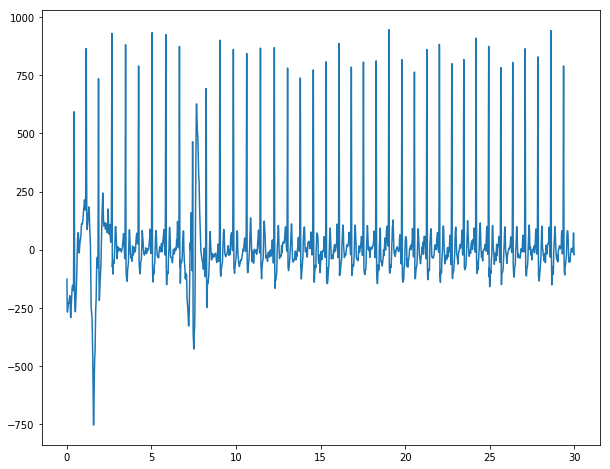

In [1]:
#Vamos a leer un par de ejemplo, así como la cabecera
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
from tfg_tools import read_challenge_mat_files, processing_ecg

ecg, header = read_challenge_mat_files('A00001.mat','./')
fs = float(header['fs'])
t = np.arange(0,len(ecg))/fs 
plt.figure(figsize = (10,8))
plt.plot(t,ecg)

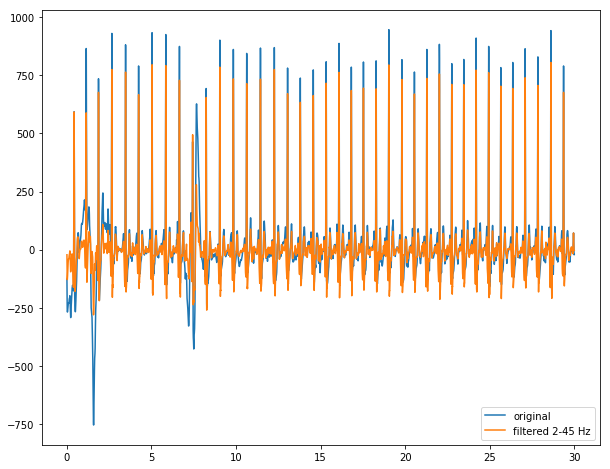

In [2]:
ecg_filtered = processing_ecg(ecg)

plt.figure(figsize = (10,8))
plt.plot(t,ecg,label='original')
plt.plot(t,ecg_filtered,label='filtered 2-45 Hz')
plt.legend()

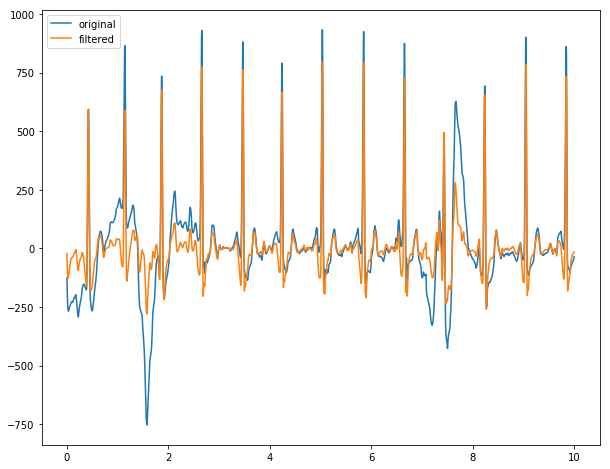

In [3]:
#zoom

plt.figure(figsize = (10,8))
plt.plot(t[t<10],ecg[t<10],label='original')
plt.plot(t[t<10],ecg_filtered[t<10],label='filtered')
plt.legend()

# Chapter Preprocesamiento y análisis exploratorio de señales

**TO DO**

* Crear una rutina que te pinte todas las señales. Un for que vaya pintando todas las señales y que en la figura se pinte información de los ejes (segundos y mv) y en la leyenda indique cómo ha sido clasificada la señal. Convendría pintar la señal original y la filtrada entre 2 y 45 Hz. Que no pase a la siguiente iteración del bucle hasta que, por ejemplo, se pulse un click de raton o alguna tecla.

* Sacar la siguiente información:
    * Número de sujetos en cada clase (esto lo puedes sacar del fichero en el que viene la clasificación de cada señal)
    * Longitudes de las señales: Una función que se cree un vector con todas las longitudes de todas las señales, y que pinte un histograma de las longitudes.
   
* Con esto podemos divisar los modeos de deep learning para clasificación


# NOTA:

<font color='red'>Miguel Ángel, lo que te pedía es que tu hicieses el análisis y completases este notebook con esa información, porque todo lo que escribas aquí, también se puede utilizar luego para la memoria</font>


### Número de sujetos en cada clase:

A continuación obtenemos el resultado de sujetos por cada clase:



In [4]:
#get the number of patietns in each class

from tfg_tools import get_distribution_classes

class_dist = get_distribution_classes()

print(class_dist)

{'A': 738, '~': 284, 'O': 2456, 'N': 5050}


Como se puede observar existe un claro desbalanceo: El caso de los registros normales es siete veces mayor que el caso de las señales con AF. Habrá que escoger alguna técnica de balanceado. Lo primero que recomendamos es echar un vistazo al siguiente post:

[Imbalanced classes](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).

De las técnicas que tenemos en este caso, yo propondría varias, teniendo en cuenta que esto es un TFG:

1. Entrenar para mejorar otra métrica que accuracy, por ejemplo $\kappa$ o $F_1 score$.
2. Random over-sampling under-sampling: podemos utilizar el siguiente módulo (imbalanced-learning)(http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html)
3. Utilizar costes diferentes dependiendo de la misclassification

### Longitudes de las señales

Un problema cuando trabajamos con modelos que no tengan en cuenta la parte dinámica es la diferente longitud de las señales. Vamos a obtener un histograma de las diferentes longitudes de señales, para tener una idea del rango de posibles longitudes, para proponer una estrategia cuando implementemos el modelo de deep learning sin memoria

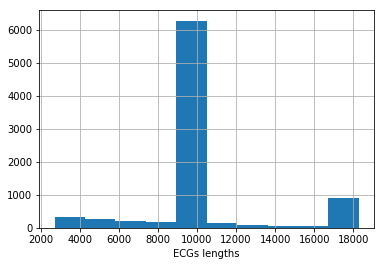

In [5]:
from tfg_tools import get_distribution_length

lengths = get_distribution_length()

In [8]:
#Número de señales con menos de 9000

print('El numero de senales con menos de 9000 es: ',np.sum(np.array(lengths)<9000))

('El numero de senales con menos de 9000 es: ', 967)


## TO-DO

Vamos a considerar **longitud de señales = 9000**, todas las que estén por debajo (967) no van a entrar en el conjunto, al menos en primera instancia. Necesitamos verificar de qué clase son las señales con menos de 9000. 

Tu próxima tarea es verificar las distribución por clases de esas 967 señales con menos de 9000. Para las que tienen más de 9000 muestras vamos a utilizar sólo las primeras 9000.

El problema lo resolveremos cuando utilicemos deep learning para series temporales.

In [9]:
from tfg_tools import get_distribution_less9000

classes_less_9000 = get_distribution_less9000()

print(classes_less_9000)



{'Normal': 521, 'Other Rhyth': 194, 'Noisy': 139, 'AF': 113}


Como podemos apreciar en los resultados de las señales con longitud menor de 9000, las señales normales son las más abundantes en comparanción con el resto. 

**Cuidado con estas afirmaciones Miguel Ángel** lo que dices es cierto, pero en valor absoluto, el problema es que no hay la misma cantidad inicial de datos, de hecho: AF 113/783 = 0.19 approx 20%, mientras que Normal 521/5050 = 0.10 approx 10%

De esta manera podemose decir que, para el caso de una NN sin memoria, con señales de entrada de longitud 9000 muestras, vamos a tener la siguiente distribución:

* **AF** = 738 - 113 = **625**
* **Noisy** = 284 - 139 = **145**
* **Other** = 2456 - 194 = **2262**
* **Normal** = 5050 - 521 = **4529**


## TO_DO

Los siguientes pasos serían:

1. Partir convenientemente los datos en training y test, yo utilizaría alguna herramienta de sklearn para mantener las proporciones (de las clases) en test, hay herramientas como stratified.
2. Elegir alguna estrategia para comenzar con el tratamiento del desbalanceo: por ejemplo: under-sampling, over-sampling (aquí, vamos a utilizar el modulo que puse anteriormente, parecido a sklearn), y métrica.
3. Constuir un esquema sencillo de red neuronal, y luego complicarlo.

In [10]:
#Example of stratified split into train and test 

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

x = np.ones(100)
y = [0,0,0,0,1,1,1,1,1,1] *10 #proportion of labels 6 out of 10 are class 1
y = np.array(y)

#split with previous shuffle. Test size = 33%

skf = StratifiedShuffleSplit(n_splits = 1,test_size = 0.33)

for train, test in skf.split(x,y):
    print("%s %s" % (train,test))

#let's check proportions

print("Proportion of class 1 in original dataset %.2f %%: " % (np.sum(y)/float(len(y))))
print("Proportion of class 1 in training dataset %.2f %%: " % (np.sum(y[train])/float(len(y[train]))))
print("Proportion of class 1 in test dataset %.2f %%: " % (np.sum(y[test])/float(len(y[test]))))

[25 13 56  1  7 92 66 12 86 35 41  0 63 10 94 30 48 17 42 40 54 60 36 29
 47 39 91 50 28 16 88  6 76 43 74  8 15 71 72 22 20 81 46 27 80 84 21 93
  5 98 64 77 34 51 90  3 55 73 99 67 24 57 45 87 78 85 95] [65 53 97 70  9 62 14 96 61 59 83 68 26 38 32 18 37 33 44 19 82 52  2 11
 79  4 31 23 89 69 58 75 49]
Proportion of class 1 in original dataset 0.60 %: 
Proportion of class 1 in training dataset 0.60 %: 
Proportion of class 1 in test dataset 0.61 %: 


## Chapter : Modelos de redes neuronales

Vamos a comenzar utilizando una red neuronal ..

$$y(t) = \frac{1}{x}$$

## Sección: Separación en Training y Test

**Miguel Ángel, comenta aquí lo que vas a hacer para realizar la separación. En las celdas siguientes crea el código para realizarlo**

Dividimos los datos en training y test. Sólo se han considerado las señales de longitud 9000. Esta información se ha dividido en 80% para training y el 20% para test. Para la separación se ha utilizado la función StratifiedShuffleSplit. A continuación se muestran los índices del conjunto de entrenamiento, seguidos de los índices del conjunto de prueba.


In [12]:
from tfg_tools import filter_data
from sklearn.model_selection import StratifiedShuffleSplit
np.set_printoptions(threshold='nan')

ecgs,tags = filter_data()
skf = StratifiedShuffleSplit(n_splits = 1,test_size = 0.20)

for train, test in skf.split(ecgs,tags):
        print("%s\n  \n%s\n" % (train,test))


[1967 1836 4534 5860 5390  798 5631 4423  731 4621 4263 5247 5707  366
 2734 5192 3232 1643 5731 4994 1272  694 1883 4221 5133 3629  138 2679
 5520 1234  934 1958 4390 5577 4516 5313  614 2266 3175 3669 2762  569
 4511 1912  544 5937 4395 5013  895 2007 5915 5296 5885 3585 1104  142
 4351 1002 2616 2996 5956  673 2014  994 2515 4022 2054 5664 5140 5182
  869 4977 5169 3170 2756 3544 1610 4641 2999 5433 5607 2521  367 1787
 4104 5733 2398 1645 2088 1946  857 2352 2417 5252 3866 3341 2644 2082
 2608 2243 3475 1254 3497 3814 1765   52  518 5570 5802 4034 4295 4050
 5288 5138 2329 5411  689 1607 4970 2083   51 4969 5499  139 5785 1953
 1697 3705 3288 2792 4881 5264 1273 4545 5120  499 4124 5559 4141 4617
 1022 2958  520 2921  413 1509 2400 2652 4725 5752 1673 2264  832  407
 5792 3986 3158  300 4106 3985 4161 2909  781 3107 2324  308  676 3323
 2173  151 3516 1108 3558  576 3798  233  779 4020 2551 4240 4468 2640
 3592 4553 5014 4041 1183 5458 4137 2704  773 4731 3752 1777 5506 5734
 2907 

In [1]:
from tfg_tools import count,filter_data
from imblearn.over_sampling import SMOTE

X,y = filter_data()  
#X_res, y_res = SMOTE(kind='svm').fit_sample(X, y)
X_res, y_res = SMOTE().fit_sample(X, y)
print count(y_res)

{'Normal': 3678, 'Other Rhyth': 3678, 'Noisy': 3678, 'AF': 3678}


Para equilibrar las clases hemos utilizado la técnica de sobremuestreo minoritario sintético (SMOTE). Esta técnica consiste en generar nuevas muestras por interpolación. Como podemos apreciar ahora todas las clases tiene el mismo número de muestras.